In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Number GPUs Available: ",len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

Number GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13627864071617382052
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14598498300403132508
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_dir = "/content/gdrive/MyDrive/eye"
width = 224
height = 224
batchSize = 32

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow
train_ds = image_dataset_from_directory(
    data_dir+"/train",
    validation_split = 0.2,
    subset = 'training',
    seed = 12,
    image_size = (width,height),
    batch_size = batchSize,
    label_mode = 'categorical'
)

validation_ds = image_dataset_from_directory(
    data_dir+"/valid",
    validation_split = 0.2,
    subset = 'validation',
    seed = 12,
    image_size = (width,height),
    batch_size = batchSize,
    label_mode = 'categorical'
)

Found 589 files belonging to 3 classes.
Using 472 files for training.
Found 120 files belonging to 3 classes.
Using 24 files for validation.


In [5]:
classNames = train_ds.class_names
print(classNames)

['flaky', 'point_flaky_mixed', 'point_like']


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision

def VGG16Model(input_shape, num_classes):
    # Load pre-trained VGG16 model without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', Recall(), Precision()]
    )

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # Adjust the input shape according to your requirements
num_classes = 4  # Assuming 2 classes: open wound and no open wound

# Create the VGG16 model
model = VGG16Model(input_shape, num_classes)

# Print model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [7]:
model1 = VGG16Model(input_shape = [width, height, 3], num_classes =len(classNames))
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

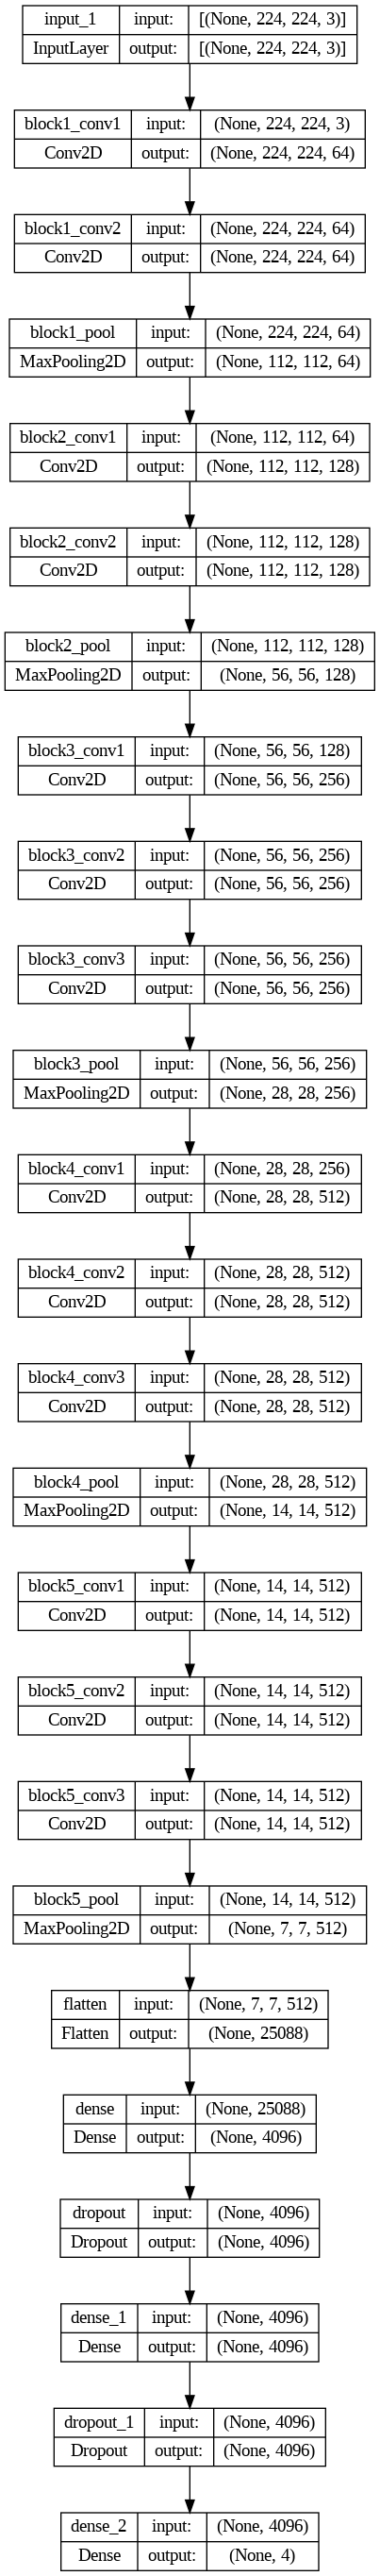

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'My Model1.png', show_shapes=True)

In [9]:
from datetime import datetime

start_time = datetime.now()

history = model1.fit(
    train_ds,
    batch_size = batchSize,
    epochs = 100,
    validation_data = validation_ds, 
    verbose = 1
)

end_time = datetime.now()

model1.save("/content/gdrive/MyDrive/eye/modelVGG16.h5")

Epoch 1/100
15/15 [==============================] - 56s 1s/step - loss: 211.2250 - accuracy: 0.5042 - recall_1: 0.5042 - precision_1: 0.5042 - val_loss: 33.3749 - val_accuracy: 0.4583 - val_recall_1: 0.4583 - val_precision_1: 0.4583
Epoch 2/100
15/15 [==============================] - 8s 318ms/step - loss: 12.8240 - accuracy: 0.6589 - recall_1: 0.6589 - precision_1: 0.6589 - val_loss: 13.7618 - val_accuracy: 0.5417 - val_recall_1: 0.5417 - val_precision_1: 0.5417
Epoch 3/100
15/15 [==============================] - 9s 295ms/step - loss: 7.9152 - accuracy: 0.7013 - recall_1: 0.7013 - precision_1: 0.7013 - val_loss: 11.4733 - val_accuracy: 0.5000 - val_recall_1: 0.5000 - val_precision_1: 0.5000
Epoch 4/100
15/15 [==============================] - 9s 402ms/step - loss: 3.4394 - accuracy: 0.8326 - recall_1: 0.8326 - precision_1: 0.8326 - val_loss: 12.4655 - val_accuracy: 0.4583 - val_recall_1: 0.4583 - val_precision_1: 0.4583
Epoch 5/100
15/15 [==============================] - 8s 300ms/s

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Average
import numpy as np

print("Average Loss: ", np.average(history.history['loss']))
print("Average accuracy: ", np.average(history.history['accuracy']))
print("Average recall: ", np.average(history.history['recall_1']))
print("Average precisions: ", np.average(history.history['precision_1']))
print("Average Val_Loss: ", np.average(history.history['val_loss']))
print("Average Val_accuracy: ", np.average(history.history['val_accuracy']))
print("Average Val_recall: ", np.average(history.history['val_recall_1']))
print("Average val_precisions: ", np.average(history.history['val_precision_1']))

Average Loss:  5.73783468067646
Average accuracy:  0.9522245770692825
Average recall:  0.9522245770692825
Average precisions:  0.9522245770692825
Average Val_Loss:  163.3154693889618
Average Val_accuracy:  0.49750000596046445
Average Val_recall:  0.49750000596046445
Average val_precisions:  0.49750000596046445


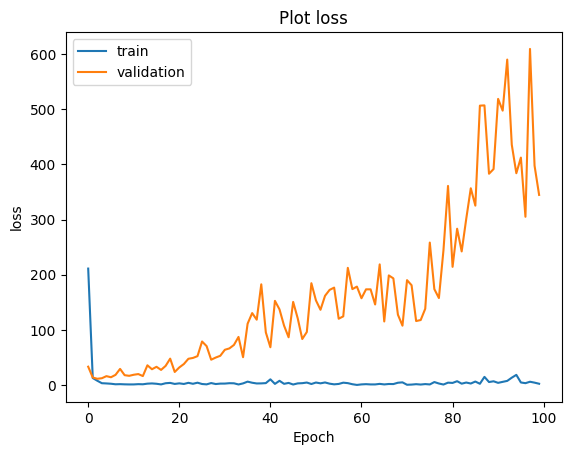

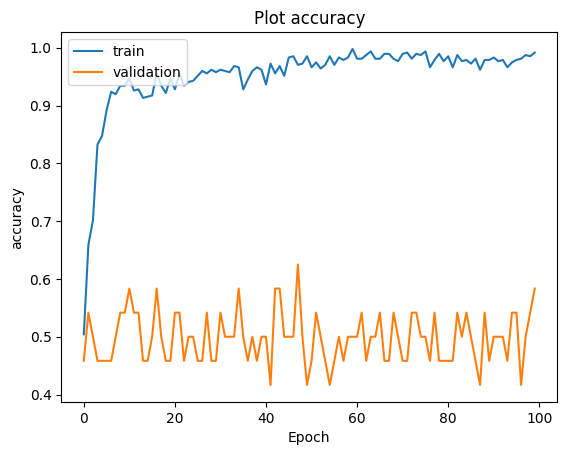

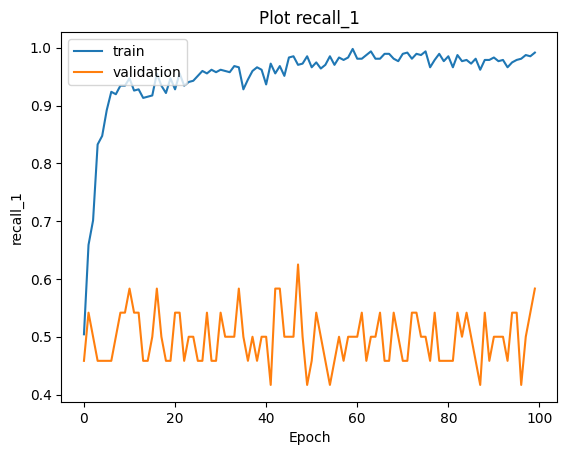

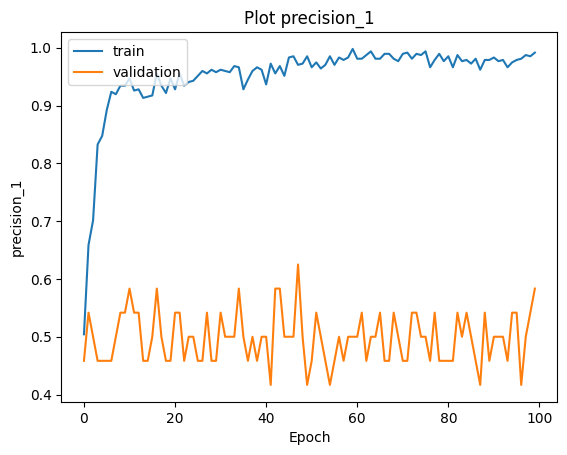

In [13]:
import matplotlib.pyplot as plt

def plot_history(hist, label):
  plt.plot(hist.history[label])
  plt.plot(hist.history['val_'+label])
  plt.title('Plot ' + label)
  plt.ylabel(label)
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

plot_history(history, 'loss')
plot_history(history, 'accuracy')
plot_history(history, 'recall_1')
plot_history(history, 'precision_1')

In [14]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/eye/modelVGG16.h5')
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [19]:
# import numpy as np
# import pandas as pd
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.math import confusion_matrix

# test_data = ImageDataGenerator()

# test_ds = test_data.flow_from_directory(
#     '/content/drive/MyDrive/eye/predict',
#     target_size = (width, height),
#     batch_size = batchSize,
#     class_mode = 'categorical'
# )

# class_names = []
# for key, value in test_ds.class_indices.items():
#   class_names.append(key)

# predictions = np.array([])
# labels = np.array([])

# for x, y in test_ds:
#   predictions = np.concatenate([predictions, np.argmax(loaded_model.predict(x), axis = -1)])
#   labels = np.concatenate([labels, np.argmax(y, axis=-1)])

# matrix = confusion_matrix(labels = label, prediction = predictions).numpy

# df = pd.DataFrame(matrix, columns = class_names, index = class_names)
# df

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
validation_generator = ImageDataGenerator()

validation_directory = '/content/drive/MyDrive/eye/predict'
validation_ds = validation_generator.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
predict = model.predict(validation_ds, steps=len(validation_ds), verbose=1)
test_labels = validation_ds.classes
confusion_mat = confusion_matrix(test_labels, predict.argmax(axis=1))

labels = list(validation_ds.class_indices.keys())
report = classification_report(test_labels, predict.argmax(axis=1), target_names=labels, labels=range(len(labels)), zero_division=1)

print("Confusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(report)

# import numpy as np
# import pandas as pd
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Get the predicted labels and true labels
# predicted_labels = np.argmax(predictions.reshape(-1, num_classes), axis=1)
# true_labels = test_ds.classes

# # Compute the classification report
# report = classification_report(true_labels, predicted_labels, target_names=classNames, output_dict=True)

# # Convert the classification report to a DataFrame
# df = pd.DataFrame(report).transpose()

# # Plot the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

# # Display the classification report DataFrame
# print(df)

# import numpy as np
# import pandas as pd
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Get the predicted labels and true labels
# predicted_labels = np.argmax(predictions.reshape(-1, num_classes), axis=1)

# true_labels = []
# for _, label in test_ds:
#     true_labels.append(label)

# true_labels = np.array(true_labels)

# # Compute the classification report
# report = classification_report(true_labels, predicted_labels, target_names=classNames, output_dict=True)

# # Convert the classification report to a DataFrame
# df = pd.DataFrame(report).transpose()

# # Plot the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

# # Display the classification report DataFrame
# print(df)

# from sklearn.metrics import confusion_matrix
# import numpy as np

# # Assuming you have a test dataset called 'test_ds'
# test_images = []
# test_labels = []
# for images, labels in validation_ds:
#     test_images.append(images.numpy())
#     test_labels.append(np.argmax(labels.numpy(), axis=1))

# test_images = np.concatenate(test_images)
# test_labels = np.concatenate(test_labels)

# # Assuming you have trained your model and stored the predictions in 'y_pred'
# y_pred = model.predict(test_images)
# y_pred = np.argmax(y_pred, axis=1)

# # Calculate the confusion matrix
# cm = confusion_matrix(test_labels, y_pred)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

Found 3 images belonging to 3 classes.
1/1 [==============================] - 0s 317ms/step
Confusion Matrix:
[[0 1 0]
 [0 1 0]
 [0 0 1]]

Classification Report:
                   precision    recall  f1-score   support

            flaky       1.00      0.00      0.00         1
point_flaky_mixed       0.50      1.00      0.67         1
      point_liked       1.00      1.00      1.00         1

         accuracy                           0.67         3
        macro avg       0.83      0.67      0.56         3
     weighted avg       0.83      0.67      0.56         3



In [20]:
model_json = model1.to_json()
with open("/content/drive/MyDrive/eye/model1.json","w") as json_file:
  json_file.write(model_json)

In [21]:
from keras.models import model_from_json
from keras.optimizers import SGD
import cv2
from google.colab.patches import cv2_imshow

In [22]:
def predict_(image_path):
    #Load the Model from Json File
    json_file = open('/content/drive/MyDrive/eye/model1.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights("/content/drive/MyDrive/eye/modelVGG16.h5")
    #Compile the model
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    #load the image you want to classify
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cv2_imshow(image)
    #predict the image
    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    if np.argmax(preds) == 0:
      print("Predicted Label: point_like")
    elif np.argmax(preds) == 1:
      print("Predicted Label: point-flaky_mixed")
    else:
      print("Predicted Label: flaky")


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


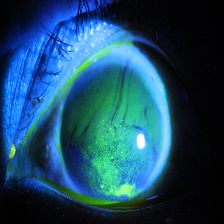

1/1 [==============================] - 1s 702ms/step
Predicted Label: flaky


In [23]:
#sesuaiin dengan lokasi filenya di drivemu
predict_("/content/drive/MyDrive/eye/predict/point_flaky_mixed/555.jpg")

In [ ]:
# import seaborn as sns
# sns.heatmap(df, annot= True, fmt='d')